In [1]:
1

1

# Setup
(No need to change anything)

In [5]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEBUG_MODE = False
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install git+https://github.com/neelnanda-io/TransformerLens.git
    # Install another version of node that makes PySvelte work way faster
    # !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    # %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Colab notebook
  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-f0upn1gw
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-f0upn1gw
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit ce82675a8e89b6d5e6229a89620c843c794f3b04
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached accelerate-0.25.0-py3-none-any.whl (265 kB)
  Using cached beartype-0.14.1-py3-none-any.whl (739 kB)
  Using cached datasets-2.15.0-py3-none-any.whl (521 kB)
  Using cached einops-0.7.0-py3-none-any.whl (44 kB)
  Using cached fancy_einsum-0.0.3-py3-none-any.whl (6.2 kB)
  Using cached jaxtyping-0.2.24-py3-none-any.whl (38 kB)
  Using cached numpy-1.26.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670

In [6]:
# # Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
# import plotly.io as pio

# if IN_COLAB or not DEBUG_MODE:
#     # Thanks to annoying rendering issues, Plotly graphics will either show up in colab OR Vscode depending on the renderer - this is bad for developing demos! Thus creating a debug mode.
#     pio.renderers.default = "colab"
# else:
#     pio.renderers.default = "png"

In [7]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [8]:
# import pysvelte

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [9]:
torch.set_grad_enabled(False)

Plotting helper functions:

In [10]:
# def imshow(tensor, renderer=None, **kwargs):
#     px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)

# def line(tensor, renderer=None, **kwargs):
#     px.line(y=utils.to_numpy(tensor), **kwargs).show(renderer)

# def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
#     x = utils.to_numpy(x)
#     y = utils.to_numpy(y)
#     px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

## Load Model

In [11]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


## Import functions from repo

In [12]:
!git clone https://github.com/callummcdougall/ARENA_2.0.git

Cloning into 'ARENA_2.0'...
remote: Enumerating objects: 9262, done.
remote: Counting objects: 100% (1976/1976), done.
remote: Compressing objects: 100% (344/344), done.
remote: Total 9262 (delta 1727), reused 1731 (delta 1628), pack-reused 7286
Receiving objects: 100% (9262/9262), 156.79 MiB | 16.10 MiB/s, done.
Resolving deltas: 100% (5620/5620), done.


In [13]:
cd ARENA_2.0/chapter1_transformers/exercises/part3_indirect_object_identification

/content/ARENA_2.0/chapter1_transformers/exercises/part3_indirect_object_identification


In [14]:
import ioi_circuit_extraction as ioi_circuit_extraction

# Generate dataset with multiple prompts

In [15]:
class Dataset:
    def __init__(self, prompts, pos_dict, tokenizer, S1_is_first=False):
        self.prompts = prompts
        self.tokenizer = tokenizer
        self.N = len(prompts)
        self.max_len = max(
            [
                len(self.tokenizer(prompt["text"]).input_ids)
                for prompt in self.prompts
            ]
        )
        # all_ids = [prompt["TEMPLATE_IDX"] for prompt in self.ioi_prompts]
        all_ids = [0 for prompt in self.prompts] # only 1 template
        all_ids_ar = np.array(all_ids)
        self.groups = []
        for id in list(set(all_ids)):
            self.groups.append(np.where(all_ids_ar == id)[0])

        texts = [ prompt["text"] for prompt in self.prompts ]
        self.toks = torch.Tensor(self.tokenizer(texts, padding=True).input_ids).type(
            torch.int
        )
        self.io_tokenIDs = [
            # self.tokenizer.encode(" " + prompt["corr"])[0] for prompt in self.prompts
            self.tokenizer.encode(prompt["corr"])[0] for prompt in self.prompts
        ]
        self.s_tokenIDs = [
            # self.tokenizer.encode(" " + prompt["incorr"])[0] for prompt in self.prompts
            self.tokenizer.encode(prompt["incorr"])[0] for prompt in self.prompts
        ]

        # word_idx: for every prompt, find the token index of each target token and "end"
        # word_idx is a tensor with an element for each prompt. The element is the targ token's ind at that prompt
        self.word_idx = {}
        # for targ in [key for key in self.prompts[0].keys() if (key != 'text' and key != 'corr' and key != 'incorr')]:
        for targ in [key for key in pos_dict]:
            targ_lst = []
            for prompt in self.prompts:
                input_text = prompt["text"]
                tokens = model.tokenizer.tokenize(input_text)
                # if S1_is_first and targ == "S1":  # only use this if first token doesn't have space Ġ in front
                #     target_token = prompt[targ]
                # else:
                #     target_token = "Ġ" + prompt[targ]
                # target_index = tokens.index(target_token)
                target_index = pos_dict[targ]
                targ_lst.append(target_index)
            self.word_idx[targ] = torch.tensor(targ_lst)

        targ_lst = []
        for prompt in self.prompts:
            input_text = prompt["text"]
            tokens = self.tokenizer.tokenize(input_text)
            end_token_index = len(tokens) - 1
            targ_lst.append(end_token_index)
        self.word_idx["end"] = torch.tensor(targ_lst)

    def __len__(self):
        return self.N

In [16]:
pwd

'/content/ARENA_2.0/chapter1_transformers/exercises/part3_indirect_object_identification'

In [17]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = '/content/digits_prompts_names.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    prompts_list = pickle.load(file)

# data now contains the contents of your pickle file
print(prompts_list[0]['text'])

prompts_list = prompts_list
#  [:240]

Marcus born in 1. Victoria born in 2. George born in 3. Brandon born in 4. Jamie born in


In [18]:
prompts_list[0]

{'S1': '1',
 'S2': '2',
 'S3': '3',
 'S4': '4',
 'corr': ' 5',
 'incorr': ' 4',
 'text': 'Marcus born in 1. Victoria born in 2. George born in 3. Brandon born in 4. Jamie born in'}

In [19]:
model.tokenizer.tokenize(prompts_list[0]['text'])

['Marcus',
 'Ġborn',
 'Ġin',
 'Ġ1',
 '.',
 'ĠVictoria',
 'Ġborn',
 'Ġin',
 'Ġ2',
 '.',
 'ĠGeorge',
 'Ġborn',
 'Ġin',
 'Ġ3',
 '.',
 'ĠBrandon',
 'Ġborn',
 'Ġin',
 'Ġ4',
 '.',
 'ĠJamie',
 'Ġborn',
 'Ġin']

In [20]:
# pos_dict = {
#     'S1': 4,
#     'S2': 10,
#     'S3': 16,
#     'S4': 22,
# }

pos_dict = {}
for i in range(len(model.tokenizer.tokenize(prompts_list[0]['text']))):
    pos_dict['S'+str(i)] = i

pos_dict

{'S0': 0,
 'S1': 1,
 'S2': 2,
 'S3': 3,
 'S4': 4,
 'S5': 5,
 'S6': 6,
 'S7': 7,
 'S8': 8,
 'S9': 9,
 'S10': 10,
 'S11': 11,
 'S12': 12,
 'S13': 13,
 'S14': 14,
 'S15': 15,
 'S16': 16,
 'S17': 17,
 'S18': 18,
 'S19': 19,
 'S20': 20,
 'S21': 21,
 'S22': 22}

In [21]:
# model.tokenizer.tokenize(prompts_list_2[0]['text'])[-1]

In [22]:
# def generate_prompts_list(x ,y):
#     prompts_list = []
#     for i in range(x, y):
#         prompt_dict = {
#             'S1': str(i),
#             'S2': str(i+1),
#             'S3': str(i+2),
#             'S4': str(i+3),
#             'corr': str(i+4),
#             'incorr': str(i+3),
#             'text': f"{i} {i+1} {i+2} {i+3}"
#         }
#         prompts_list.append(prompt_dict)
#     return prompts_list

# prompts_list = generate_prompts_list(1, 101)

dataset = Dataset(prompts_list, pos_dict, model.tokenizer, S1_is_first=True)

In [23]:
import random

def generate_prompts_list_corr(prompt_list):
    outlist = []
    for prompt_dict in prompts_list:
        r1 = random.randint(1, 12)
        r2 = random.randint(1, 12)
        while True:
            r3 = random.randint(1, 12)
            r4 = random.randint(1, 12)
            if r4 - 1 != r3:
                break
        new_text = prompt_dict['text'].replace(prompt_dict['S1'], str(r1)).replace(prompt_dict['S2'], str(r2)).replace(prompt_dict['S3'], str(r3)).replace(prompt_dict['S4'], str(r4))
        new_prompt_dict = {
            'S1': str(r1),
            'S2': str(r2),
            'S3': str(r3),
            'S4': str(r4),
            'corr': prompt_dict['corr'],
            'incorr': prompt_dict['incorr'],
            'text': new_text
        }
        outlist.append(new_prompt_dict)
    return outlist
#  f"{r1} {r2} {r3} {r4}"
prompts_list_2 = generate_prompts_list_corr(prompts_list)
# dataset_2 = Dataset(prompts_list_2, pos_dict, model.tokenizer, S1_is_first=True)
# print(prompts_list[514])
# prompts_list_2[514]

In [24]:
prompts_list_2[0]

{'S1': '6',
 'S2': '12',
 'S3': '9',
 'S4': '1',
 'corr': ' 5',
 'incorr': ' 4',
 'text': 'Marcus born in 6. Victoria born in 12. George born in 9. Brandon born in 1. Jamie born in'}

In [25]:
# model.tokenizer.tokenize(prompts_list_2[0]['text']).index('Ġ12')

In [26]:
dataset_2 = Dataset(prompts_list_2, pos_dict, model.tokenizer, S1_is_first=True)

# Ablation Expm Functions

In [27]:
from torch import Tensor

def logits_to_ave_logit_diff_2(logits: Float[Tensor, "batch seq d_vocab"], dataset: Dataset, per_prompt=False):
    '''
    Returns logit difference between the correct and incorrect answer.

    If per_prompt=True, return the array of differences rather than the average.
    '''

    # Only the final logits are relevant for the answer
    # Get the logits corresponding to the indirect object / subject tokens respectively
    io_logits: Float[Tensor, "batch"] = logits[range(logits.size(0)), dataset.word_idx["end"], dataset.io_tokenIDs]
    s_logits: Float[Tensor, "batch"] = logits[range(logits.size(0)), dataset.word_idx["end"], dataset.s_tokenIDs]
    # Find logit difference
    answer_logit_diff = io_logits - s_logits
    return answer_logit_diff if per_prompt else answer_logit_diff.mean()

In [28]:
torch.cuda.empty_cache()

In [29]:
import gc
gc.collect()

0

In [30]:
model.reset_hooks(including_permanent=True)
ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)
orig_score = logits_to_ave_logit_diff_2(ioi_logits_original, dataset)

In [31]:
orig_score

tensor(6.0147, device='cuda:0')

In [32]:
def mean_ablate_by_lst(lst, model, orig_score, print_output=True):
    # CIRCUIT = {
    #     "number mover": lst,
    #     "number mover 4": lst,
    #     "number mover 3": lst,
    #     "number mover 2": lst,
    #     "number mover 1": lst,
    # }

    # SEQ_POS_TO_KEEP = {
    #     "number mover": "end",
    #     "number mover 4": "S4",
    #     "number mover 3": "S3",
    #     "number mover 2": "S2",
    #     "number mover 1": "S1",
    # }
    CIRCUIT = {}
    SEQ_POS_TO_KEEP = {}
    for i in range(len(model.tokenizer.tokenize(prompts_list_2[0]['text']))):
        CIRCUIT['S'+str(i)] = lst
        if i == len(model.tokenizer.tokenize(prompts_list_2[0]['text'])) - 1:
            SEQ_POS_TO_KEEP['S'+str(i)] = 'end'
        else:
            SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)

    model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

    # ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)

    model = ioi_circuit_extraction.add_mean_ablation_hook(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
    ioi_logits_minimal = model(dataset.toks)

    # orig_score = logits_to_ave_logit_diff_2(ioi_logits_original, dataset)
    new_score = logits_to_ave_logit_diff_2(ioi_logits_minimal, dataset)
    if print_output:
        # print(f"Average logit difference (IOI dataset, using entire model): {orig_score:.4f}")
        # print(f"Average logit difference (IOI dataset, only using circuit): {new_score:.4f}")
        print(f"Average logit difference (circuit / full) %: {100 * new_score / orig_score:.4f}")
    # return new_score
    return 100 * new_score / orig_score

In [33]:
def find_circuit_forw(curr_circuit=None, orig_score=100, threshold=10):
    # threshold is T, a %. if performance is less than T%, allow its removal
    if curr_circuit == []:
        # Start with full circuit
        curr_circuit = [(layer, head) for layer in range(12) for head in range(12)]

    for layer in range(0, 12):
        for head in range(12):
            if (layer, head) not in curr_circuit:
                continue

            # Copying the curr_circuit so we can iterate over one and modify the other
            copy_circuit = curr_circuit.copy()

            # Temporarily removing the current tuple from the copied circuit
            copy_circuit.remove((layer, head))

            new_score = mean_ablate_by_lst(copy_circuit, model, orig_score, print_output=False).item()

            # print((layer,head), new_score)
            # If the result is less than the threshold, remove the tuple from the original list
            if (100 - new_score) < threshold:
                curr_circuit.remove((layer, head))

                print("\nRemoved:", (layer, head))
                print(new_score)

    return curr_circuit, new_score

In [34]:
def find_circuit_backw(curr_circuit=None, orig_score=100, threshold=10):
    # threshold is T, a %. if performance is less than T%, allow its removal
    if curr_circuit == []:
        # Start with full circuit
        curr_circuit = [(layer, head) for layer in range(12) for head in range(12)]

    for layer in range(11, -1, -1):  # go thru all heads in a layer first
        for head in range(12):
            if (layer, head) not in curr_circuit:
                continue

            # Copying the curr_circuit so we can iterate over one and modify the other
            copy_circuit = curr_circuit.copy()

            # Temporarily removing the current tuple from the copied circuit
            copy_circuit.remove((layer, head))

            new_score = mean_ablate_by_lst(copy_circuit, model, orig_score, print_output=False).item()

            # If the result is less than the threshold, remove the tuple from the original list
            if (100 - new_score) < threshold:
                curr_circuit.remove((layer, head))

                print("\nRemoved:", (layer, head))
                print(new_score)

    return curr_circuit, new_score

# rmv most impt heads from full

In [35]:
circ = [(layer, head) for layer in range(12) for head in range(12)]
lh_scores = {}
for lh in circ:
    copy_circuit = circ.copy()
    copy_circuit.remove(lh)
    print("removed: " + str(lh))
    new_score = mean_ablate_by_lst(copy_circuit, model, orig_score, print_output=True).item()
    lh_scores[lh] = new_score

removed: (0, 0)
Average logit difference (circuit / full) %: 100.6066
removed: (0, 1)
Average logit difference (circuit / full) %: 95.8189
removed: (0, 2)
Average logit difference (circuit / full) %: 99.8102
removed: (0, 3)
Average logit difference (circuit / full) %: 99.4126
removed: (0, 4)
Average logit difference (circuit / full) %: 100.2767
removed: (0, 5)
Average logit difference (circuit / full) %: 98.7765
removed: (0, 6)
Average logit difference (circuit / full) %: 100.4842
removed: (0, 7)
Average logit difference (circuit / full) %: 100.4501
removed: (0, 8)
Average logit difference (circuit / full) %: 99.9530
removed: (0, 9)
Average logit difference (circuit / full) %: 99.4598
removed: (0, 10)
Average logit difference (circuit / full) %: 101.0147
removed: (0, 11)
Average logit difference (circuit / full) %: 99.9905
removed: (1, 0)
Average logit difference (circuit / full) %: 100.4575
removed: (1, 1)
Average logit difference (circuit / full) %: 100.0048
removed: (1, 2)
Average l

In [36]:
# Sort the dictionary by values in descending order
sorted_lh_scores = dict(sorted(lh_scores.items(), key=lambda item: -item[1], reverse=True))

# Select the top 10 items
top_10_lh_scores = dict(list(sorted_lh_scores.items())[:10])
top_10_lh_scores

{(7, 11): 46.95252990722656,
 (4, 4): 79.87974548339844,
 (1, 5): 82.1259536743164,
 (10, 7): 86.01123046875,
 (8, 8): 86.2258071899414,
 (8, 6): 89.6979751586914,
 (9, 1): 90.54792785644531,
 (6, 6): 91.7734375,
 (8, 1): 93.57736206054688,
 (6, 10): 93.74057006835938}

In [37]:
# for lh, score in sorted_lh_scores.items():
#     print(lh, -round(100-score, 2))

# Sort the dictionary by values in descending order
sorted_lh_scores = sorted(lh_scores.items(), key=lambda item: -item[1], reverse=True)

# Iterate over the top 10 items and print them
for lh, score in sorted_lh_scores[:10]:
    modified_score = -round(100 - score, 2)
    print(lh, modified_score)

(7, 11) -53.05
(4, 4) -20.12
(1, 5) -17.87
(10, 7) -13.99
(8, 8) -13.77
(8, 6) -10.3
(9, 1) -9.45
(6, 6) -8.23
(8, 1) -6.42
(6, 10) -6.26


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

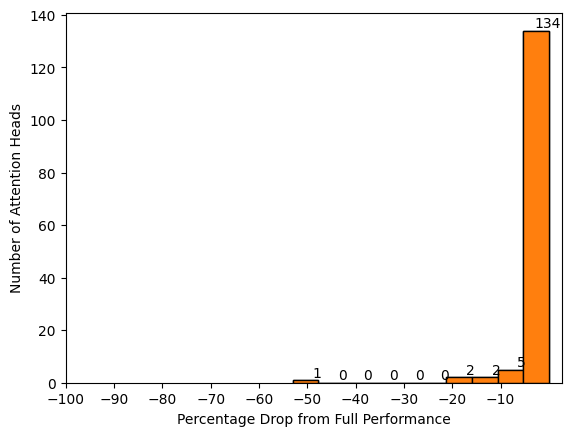

In [41]:
from google.colab import files

lh_scores_drop = {key: min(0, val-100) for key, val in lh_scores.items()}

# Extracting only the values (scores) from the dictionary
scores = list(lh_scores_drop.values())

# Creating a histogram for the scores
plt.hist(scores, bins=10, edgecolor='black')  # Adjust the number of bins as needed

# Creating a histogram for the scores
n, bins, patches = plt.hist(scores, bins=10, edgecolor='black')  # Adjust the number of bins as needed

# Annotating the histogram with the number of values in each bin
for i in range(len(n)):
    plt.text(bins[i]+5, n[i], str(int(n[i])), va='bottom', ha='center')

# Setting x-axis ticks at intervals of 10 from 0 to 100
plt.xticks(range(-100, 0, 10))

# Adding labels and title for clarity
plt.xlabel('Percentage Drop from Full Performance')
plt.ylabel('Number of Attention Heads')
# plt.title('Distribution of Attention Head Performance Drop Percentages')

# Displaying the plot
# plt.show()

# Save the figure
pdf_filename = 'lh_scores_distribution.pdf'
plt.savefig(pdf_filename)

# Download the file in Colab
files.download(pdf_filename)

In [42]:
import statistics

# Assuming lh_scores_drop is already defined
# For example, lh_scores_drop = {key: max(0, 100 - val) for key, val in lh_scores.items()}

# Extracting the values from the dictionary
scores = list(lh_scores_drop.values())

# Calculating the mean
mean_score = statistics.mean(scores)

print("Mean of the scores:", mean_score)


Mean of the scores: -1.5397760073343914


In [43]:
def get_probability_ranking(value, distribution):
    # Convert distribution to a probability distribution (if not already)
    total = sum(distribution)
    prob_distribution = [x / total for x in distribution]

    # Sort the probability distribution
    sorted_distribution = sorted(prob_distribution)

    # Calculate the cumulative probability up to the given value
    cumulative_prob = sum(prob for prob in sorted_distribution if prob <= value)

    return cumulative_prob

# Example usage
distribution = lh_scores_drop.values()
value = -0.69  # Value to get the probability ranking for
ranking = get_probability_ranking(value, distribution)
print(f"Probability Ranking of {value} in the distribution: {ranking}")


Probability Ranking of -0.69 in the distribution: 0


# iter backw fwd, threshold 3

In [ ]:
threshold = 3
curr_circuit = []
prev_score = 100
new_score = 0
iter = 1
while prev_score != new_score:
    print('\nbackw prune, iter ', str(iter))
    # prev_score = new_score # save old score before finding new one
    old_circuit = curr_circuit.copy() # save old before finding new one
    curr_circuit, new_score = find_circuit_backw(curr_circuit=curr_circuit, orig_score=orig_score, threshold=threshold)
    if curr_circuit == old_circuit:
        break
    print('\nfwd prune, iter ', str(iter))
    # track changes in circuit as for some reason it doesn't work with scores
    old_circuit = curr_circuit.copy() # save old before finding new one
    curr_circuit, new_score = find_circuit_forw(curr_circuit=curr_circuit, orig_score=orig_score, threshold=threshold)
    if curr_circuit == old_circuit:
        break
    iter += 1

In [ ]:
bf_3 = curr_circuit.copy()
bf_3

In [ ]:
len(bf_3)

## loop rmv and check for most impt heads

In [ ]:
circ = bf_3
circ_score = mean_ablate_by_lst(circ, model, orig_score, print_output=True).item()

In [ ]:
lh_scores = {}
for lh in circ:
    copy_circuit = circ.copy()
    copy_circuit.remove(lh)
    print("removed: " + str(lh))
    new_score = mean_ablate_by_lst(copy_circuit, model, orig_score, print_output=True).item()
    lh_scores[lh] = new_score

In [ ]:
sorted_lh_scores = dict(sorted(lh_scores.items(), key=lambda item: item[1]))
sorted_lh_scores

In [ ]:
for lh, score in sorted_lh_scores.items():
    print(lh, -round(circ_score-score, 2))

## try other tasks circs

### gt, IOI

In [ ]:
# greater-than
circuit = [(0, 1), (0, 3), (0, 5), (5, 5), (6, 1), (6, 9), (7, 10), (8, 11), (9, 1)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

In [ ]:
# IOI
circuit = [(0, 1), (0, 10), (2, 2), (3, 0), (4, 11), (5, 5), (5, 8), (5, 9), (6, 9), (7, 3), (7, 9), (8, 6), (8, 10), (9, 0), (9, 6), (9, 7), (9, 9), (10, 0), (10, 1), (10, 2), (10, 6), (10, 7), (10, 10), (11, 2), (11, 9), (11, 10)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

### bf 80

In [ ]:
# # fb 80, digits incr
# # https://colab.research.google.com/drive/1mFWmGAKtigFcqqWWMCwU7wWQY2HT5ZOo#scrollTo=lJEY-Zs2g_a5&line=1&uniqifier=1
# circuit = [(1, 5), (3, 3), (3, 7), (3, 10), (3, 11), (4, 4), (4, 6), (4, 7), (4, 10), (4, 11), (5, 0), (5, 2), (5, 3), (5, 4), (5, 6), (6, 3), (6, 8), (6, 10), (7, 0), (7, 2), (7, 7), (7, 8), (7, 10), (7, 11), (8, 0), (8, 1), (8, 6), (8, 8), (8, 9), (8, 11), (9, 1), (11, 8)]
# mean_ablate_by_lst(circuit, model, print_output=True).item()

In [ ]:
# # fb 80, numwords
# # https://colab.research.google.com/drive/1QTv-4osLHadCAay0beew-xlXszPCG88s#scrollTo=563kZf_4r_mw&line=2&uniqifier=1
# circuit = [(3, 2), (4, 4), (4, 8), (4, 10), (4, 11), (5, 5), (5, 6), (5, 7), (5, 8), (6, 1), (6, 7), (6, 9), (6, 10), (7, 0), (7, 2), (7, 5), (7, 6), (7, 7), (7, 8), (7, 10), (7, 11), (8, 0), (8, 1), (8, 6), (8, 8), (8, 11), (9, 1), (10, 2)]
# mean_ablate_by_lst(circuit, model, print_output=True).item()

In [ ]:
# # fb 80, months
# # https://colab.research.google.com/drive/1lhQqlizYGMC11vzp6I9mJ3dyxIr8tV3l#scrollTo=563kZf_4r_mw&line=2&uniqifier=1
# circuit = [(4, 4), (7, 11), (8, 6), (8, 9), (8, 11), (9, 1), (9, 5), (11, 10)]
# mean_ablate_by_lst(circuit, model, print_output=True).item()

### bf 97

In [ ]:
# digits incr
# incorr i+3
circuit = [(0, 1), (0, 2), (0, 5), (0, 7), (0, 8), (0, 10), (1, 0), (1, 1), (1, 3), (1, 5), (1, 7), (1, 11), (2, 0), (2, 1), (2, 2), (2, 3), (2, 5), (2, 6), (2, 8), (2, 9), (2, 10), (3, 3), (3, 7), (3, 8), (3, 10), (3, 11), (4, 2), (4, 4), (4, 6), (4, 10), (4, 11), (5, 1), (5, 4), (5, 8), (5, 10), (5, 11), (6, 2), (6, 3), (6, 4), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (7, 11), (8, 6), (8, 8), (9, 1), (10, 7), (11, 10)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

In [ ]:
# numwords
# incorr i+3
circuit = [(0, 1), (0, 6), (0, 7), (0, 9), (0, 10), (1, 0), (1, 5), (3, 3), (4, 4), (4, 10), (5, 4), (5, 6), (5, 8), (6, 6), (6, 10), (7, 6), (7, 10), (7, 11), (8, 8), (9, 1), (10, 7)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

In [ ]:
# months
# incorr i
circuit = [(0, 1), (2, 3), (2, 5), (2, 7), (2, 8), (2, 9), (4, 4), (5, 0), (5, 6), (6, 9), (6, 10), (7, 8), (7, 11), (8, 1), (8, 6), (8, 8), (8, 9), (9, 1), (9, 7), (9, 11), (10, 7), (11, 10)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

# iter backw fwd, threshold 20

In [ ]:
threshold = 20
curr_circuit = []
prev_score = 100
new_score = 0
iter = 1
while prev_score != new_score:
    print('\nbackw prune, iter ', str(iter))
    # prev_score = new_score # save old score before finding new one
    old_circuit = curr_circuit.copy() # save old before finding new one
    curr_circuit, new_score = find_circuit_backw(curr_circuit=curr_circuit, orig_score=orig_score, threshold=threshold)
    if curr_circuit == old_circuit:
        break
    print('\nfwd prune, iter ', str(iter))
    # track changes in circuit as for some reason it doesn't work with scores
    old_circuit = curr_circuit.copy() # save old before finding new one
    curr_circuit, new_score = find_circuit_forw(curr_circuit=curr_circuit, orig_score=orig_score, threshold=threshold)
    if curr_circuit == old_circuit:
        break
    iter += 1

In [ ]:
bf_3 = curr_circuit.copy()
bf_3

In [ ]:
len(bf_3)

## loop rmv and check for most impt heads

In [ ]:
circ = bf_3
circ_score = mean_ablate_by_lst(circ, model, orig_score, print_output=True).item()

In [ ]:
lh_scores = {}
for lh in circ:
    copy_circuit = circ.copy()
    copy_circuit.remove(lh)
    print("removed: " + str(lh))
    new_score = mean_ablate_by_lst(copy_circuit, model, orig_score, print_output=True).item()
    lh_scores[lh] = new_score

In [ ]:
sorted_lh_scores = dict(sorted(lh_scores.items(), key=lambda item: item[1]))
sorted_lh_scores

In [ ]:
for lh, score in sorted_lh_scores.items():
    print(lh, -round(circ_score-score, 2))

## try other tasks circs

### bf 80

In [ ]:
circuit = [(0, 1), (0, 2), (0, 5), (0, 7), (0, 8), (0, 10), (1, 0), (1, 1), (1, 5), (1, 7), (1, 11), (2, 0), (2, 1), (2, 2), (2, 3), (2, 6), (2, 8), (2, 9), (2, 10), (2, 11), (3, 3), (3, 4), (3, 5), (3, 7), (3, 8), (3, 9), (3, 11), (4, 4), (4, 10), (5, 1), (5, 4), (5, 6), (5, 8), (5, 11), (6, 4), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (7, 11), (9, 1)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

In [ ]:
# numwords
circuit = [(0, 1), (0, 9), (0, 10), (1, 5), (4, 4), (4, 7), (5, 6), (5, 8), (6, 1), (6, 6), (6, 10), (7, 5), (7, 6), (7, 10), (7, 11), (8, 7), (8, 8), (8, 10), (8, 11), (9, 1)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

In [ ]:
# months
circuit = [(0, 1), (2, 2), (2, 9), (4, 4), (5, 0), (5, 1), (5, 4), (5, 6), (6, 6), (6, 9), (6, 10), (7, 7), (7, 11), (8, 8), (8, 9), (9, 1)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

# try again using incorr logit i

In [ ]:
def generate_prompts_list(x ,y):
    prompts_list = []
    for i in range(x, y):
        prompt_dict = {
            'S1': str(i),
            'S2': str(i+1),
            'S3': str(i+2),
            'S4': str(i+3),
            'corr': str(i+4),
            'incorr': str(i),
            'text': f"{i} {i+1} {i+2} {i+3}"
        }
        prompts_list.append(prompt_dict)
    return prompts_list

prompts_list = generate_prompts_list(1, 101)
dataset = Dataset(prompts_list, pos_dict, model.tokenizer, S1_is_first=True)

In [ ]:
model.reset_hooks(including_permanent=True)
ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)
orig_score = logits_to_ave_logit_diff_2(ioi_logits_original, dataset)

## iter backw fwd, threshold 3

In [ ]:
threshold = 3
curr_circuit = []
prev_score = 100
new_score = 0
iter = 1
while prev_score != new_score:
    print('\nbackw prune, iter ', str(iter))
    # prev_score = new_score # save old score before finding new one
    old_circuit = curr_circuit.copy() # save old before finding new one
    curr_circuit, new_score = find_circuit_backw(curr_circuit=curr_circuit, orig_score=orig_score, threshold=threshold)
    if curr_circuit == old_circuit:
        break
    print('\nfwd prune, iter ', str(iter))
    # track changes in circuit as for some reason it doesn't work with scores
    old_circuit = curr_circuit.copy() # save old before finding new one
    curr_circuit, new_score = find_circuit_forw(curr_circuit=curr_circuit, orig_score=orig_score, threshold=threshold)
    if curr_circuit == old_circuit:
        break
    iter += 1

In [ ]:
bf_3 = curr_circuit.copy()
bf_3

In [ ]:
len(bf_3)

## loop rmv and check for most impt heads

In [ ]:
circ = bf_3
circ_score = mean_ablate_by_lst(circ, model, orig_score, print_output=True).item()

In [ ]:
lh_scores = {}
for lh in circ:
    copy_circuit = circ.copy()
    copy_circuit.remove(lh)
    print("removed: " + str(lh))
    new_score = mean_ablate_by_lst(copy_circuit, model, orig_score, print_output=True).item()
    lh_scores[lh] = new_score

In [ ]:
sorted_lh_scores = dict(sorted(lh_scores.items(), key=lambda item: item[1]))
sorted_lh_scores

In [ ]:
for lh, score in sorted_lh_scores.items():
    print(lh, -round(circ_score-score, 2))

## try other tasks circs

### gt, IOI

In [ ]:
# greater-than
circuit = [(0, 1), (0, 3), (0, 5), (5, 5), (6, 1), (6, 9), (7, 10), (8, 11), (9, 1)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

In [ ]:
# IOI
circuit = [(0, 1), (0, 10), (2, 2), (3, 0), (4, 11), (5, 5), (5, 8), (5, 9), (6, 9), (7, 3), (7, 9), (8, 6), (8, 10), (9, 0), (9, 6), (9, 7), (9, 9), (10, 0), (10, 1), (10, 2), (10, 6), (10, 7), (10, 10), (11, 2), (11, 9), (11, 10)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

### bf 80

In [ ]:
# # fb 80, digits incr
# # https://colab.research.google.com/drive/1mFWmGAKtigFcqqWWMCwU7wWQY2HT5ZOo#scrollTo=lJEY-Zs2g_a5&line=1&uniqifier=1
# circuit = [(1, 5), (3, 3), (3, 7), (3, 10), (3, 11), (4, 4), (4, 6), (4, 7), (4, 10), (4, 11), (5, 0), (5, 2), (5, 3), (5, 4), (5, 6), (6, 3), (6, 8), (6, 10), (7, 0), (7, 2), (7, 7), (7, 8), (7, 10), (7, 11), (8, 0), (8, 1), (8, 6), (8, 8), (8, 9), (8, 11), (9, 1), (11, 8)]
# mean_ablate_by_lst(circuit, model, print_output=True).item()

In [ ]:
# # fb 80, numwords
# # https://colab.research.google.com/drive/1QTv-4osLHadCAay0beew-xlXszPCG88s#scrollTo=563kZf_4r_mw&line=2&uniqifier=1
# circuit = [(3, 2), (4, 4), (4, 8), (4, 10), (4, 11), (5, 5), (5, 6), (5, 7), (5, 8), (6, 1), (6, 7), (6, 9), (6, 10), (7, 0), (7, 2), (7, 5), (7, 6), (7, 7), (7, 8), (7, 10), (7, 11), (8, 0), (8, 1), (8, 6), (8, 8), (8, 11), (9, 1), (10, 2)]
# mean_ablate_by_lst(circuit, model, print_output=True).item()

In [ ]:
# # fb 80, months
# # https://colab.research.google.com/drive/1lhQqlizYGMC11vzp6I9mJ3dyxIr8tV3l#scrollTo=563kZf_4r_mw&line=2&uniqifier=1
# circuit = [(4, 4), (7, 11), (8, 6), (8, 9), (8, 11), (9, 1), (9, 5), (11, 10)]
# mean_ablate_by_lst(circuit, model, print_output=True).item()

### bf 97

In [ ]:
# digits incr
# incorr i+3
circuit = [(0, 1), (0, 2), (0, 5), (0, 7), (0, 8), (0, 10), (1, 0), (1, 1), (1, 3), (1, 5), (1, 7), (1, 11), (2, 0), (2, 1), (2, 2), (2, 3), (2, 5), (2, 6), (2, 8), (2, 9), (2, 10), (3, 3), (3, 7), (3, 8), (3, 10), (3, 11), (4, 2), (4, 4), (4, 6), (4, 10), (4, 11), (5, 1), (5, 4), (5, 8), (5, 10), (5, 11), (6, 2), (6, 3), (6, 4), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (7, 11), (8, 6), (8, 8), (9, 1), (10, 7), (11, 10)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

In [ ]:
# numwords
# incorr i+3
circuit = [(0, 1), (0, 6), (0, 7), (0, 9), (0, 10), (1, 0), (1, 5), (3, 3), (4, 4), (4, 10), (5, 4), (5, 6), (5, 8), (6, 6), (6, 10), (7, 6), (7, 10), (7, 11), (8, 8), (9, 1), (10, 7)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

In [ ]:
# months
# incorr i
circuit = [(0, 1), (2, 3), (2, 5), (2, 7), (2, 8), (2, 9), (4, 4), (5, 0), (5, 6), (6, 9), (6, 10), (7, 8), (7, 11), (8, 1), (8, 6), (8, 8), (8, 9), (9, 1), (9, 7), (9, 11), (10, 7), (11, 10)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

# try again using incorr logit i+3 but rand decades, no seq in last two

In [ ]:
def generate_prompts_list(x ,y):
    prompts_list = []
    for i in range(x, y):
        prompt_dict = {
            'S1': str(i),
            'S2': str(i+1),
            'S3': str(i+2),
            'S4': str(i+3),
            'corr': str(i+4),
            'incorr': str(i),
            'text': f"{i} {i+1} {i+2} {i+3}"
        }
        prompts_list.append(prompt_dict)
    return prompts_list

prompts_list = generate_prompts_list(1, 101)
dataset = Dataset(prompts_list, pos_dict, model.tokenizer, S1_is_first=True)

In [ ]:
import random

def generate_prompts_list_corr(x ,y):
    prompts_list = []
    for i in range(x, y):
        rDecade = random.randint(1, 9)*10
        r1 = random.randint(rDecade, 10+rDecade)
        r2 = random.randint(rDecade, 10+rDecade)
        while True:
            r3 = random.randint(rDecade, 10+rDecade)
            r4 = random.randint(rDecade, 10+rDecade)
            if r4 - 1 != r3:
                break
        prompt_dict = {
            'S1': str(r1),
            'S2': str(r2),
            'S3': str(r3),
            'S4': str(r4),
            'corr': str(i+4),
            'incorr': str(i+3),
            'text': f"{r1} {r2} {r3} {r4}"
        }
        prompts_list.append(prompt_dict)
    return prompts_list

prompts_list_2 = generate_prompts_list_corr(1, 101)
dataset_2 = Dataset(prompts_list_2, pos_dict, model.tokenizer, S1_is_first=True)
prompts_list_2

In [ ]:
model.reset_hooks(including_permanent=True)
ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)
orig_score = logits_to_ave_logit_diff_2(ioi_logits_original, dataset)

## iter backw fwd, threshold 3

In [ ]:
threshold = 3
curr_circuit = []
prev_score = 100
new_score = 0
iter = 1
while prev_score != new_score:
    print('\nbackw prune, iter ', str(iter))
    # prev_score = new_score # save old score before finding new one
    old_circuit = curr_circuit.copy() # save old before finding new one
    curr_circuit, new_score = find_circuit_backw(curr_circuit=curr_circuit, orig_score=orig_score, threshold=threshold)
    if curr_circuit == old_circuit:
        break
    print('\nfwd prune, iter ', str(iter))
    # track changes in circuit as for some reason it doesn't work with scores
    old_circuit = curr_circuit.copy() # save old before finding new one
    curr_circuit, new_score = find_circuit_forw(curr_circuit=curr_circuit, orig_score=orig_score, threshold=threshold)
    if curr_circuit == old_circuit:
        break
    iter += 1

In [ ]:
bf_3 = curr_circuit.copy()
bf_3

In [ ]:
len(bf_3)

## loop rmv and check for most impt heads

In [ ]:
circ = bf_3
circ_score = mean_ablate_by_lst(circ, model, orig_score, print_output=True).item()

In [ ]:
lh_scores = {}
for lh in circ:
    copy_circuit = circ.copy()
    copy_circuit.remove(lh)
    print("removed: " + str(lh))
    new_score = mean_ablate_by_lst(copy_circuit, model, orig_score, print_output=True).item()
    lh_scores[lh] = new_score

In [ ]:
sorted_lh_scores = dict(sorted(lh_scores.items(), key=lambda item: item[1]))
sorted_lh_scores

In [ ]:
for lh, score in sorted_lh_scores.items():
    print(lh, -round(circ_score-score, 2))

## try other tasks circs

### gt, IOI

In [ ]:
# greater-than
circuit = [(0, 1), (0, 3), (0, 5), (5, 5), (6, 1), (6, 9), (7, 10), (8, 11), (9, 1)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

In [ ]:
# IOI
circuit = [(0, 1), (0, 10), (2, 2), (3, 0), (4, 11), (5, 5), (5, 8), (5, 9), (6, 9), (7, 3), (7, 9), (8, 6), (8, 10), (9, 0), (9, 6), (9, 7), (9, 9), (10, 0), (10, 1), (10, 2), (10, 6), (10, 7), (10, 10), (11, 2), (11, 9), (11, 10)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

### bf 80

In [ ]:
# # fb 80, digits incr
# # https://colab.research.google.com/drive/1mFWmGAKtigFcqqWWMCwU7wWQY2HT5ZOo#scrollTo=lJEY-Zs2g_a5&line=1&uniqifier=1
# circuit = [(1, 5), (3, 3), (3, 7), (3, 10), (3, 11), (4, 4), (4, 6), (4, 7), (4, 10), (4, 11), (5, 0), (5, 2), (5, 3), (5, 4), (5, 6), (6, 3), (6, 8), (6, 10), (7, 0), (7, 2), (7, 7), (7, 8), (7, 10), (7, 11), (8, 0), (8, 1), (8, 6), (8, 8), (8, 9), (8, 11), (9, 1), (11, 8)]
# mean_ablate_by_lst(circuit, model, print_output=True).item()

In [ ]:
# # fb 80, numwords
# # https://colab.research.google.com/drive/1QTv-4osLHadCAay0beew-xlXszPCG88s#scrollTo=563kZf_4r_mw&line=2&uniqifier=1
# circuit = [(3, 2), (4, 4), (4, 8), (4, 10), (4, 11), (5, 5), (5, 6), (5, 7), (5, 8), (6, 1), (6, 7), (6, 9), (6, 10), (7, 0), (7, 2), (7, 5), (7, 6), (7, 7), (7, 8), (7, 10), (7, 11), (8, 0), (8, 1), (8, 6), (8, 8), (8, 11), (9, 1), (10, 2)]
# mean_ablate_by_lst(circuit, model, print_output=True).item()

In [ ]:
# # fb 80, months
# # https://colab.research.google.com/drive/1lhQqlizYGMC11vzp6I9mJ3dyxIr8tV3l#scrollTo=563kZf_4r_mw&line=2&uniqifier=1
# circuit = [(4, 4), (7, 11), (8, 6), (8, 9), (8, 11), (9, 1), (9, 5), (11, 10)]
# mean_ablate_by_lst(circuit, model, print_output=True).item()

### bf 97

In [ ]:
# digits incr
# incorr i+3
circuit = [(0, 1), (0, 2), (0, 5), (0, 7), (0, 8), (0, 10), (1, 0), (1, 1), (1, 3), (1, 5), (1, 7), (1, 11), (2, 0), (2, 1), (2, 2), (2, 3), (2, 5), (2, 6), (2, 8), (2, 9), (2, 10), (3, 3), (3, 7), (3, 8), (3, 10), (3, 11), (4, 2), (4, 4), (4, 6), (4, 10), (4, 11), (5, 1), (5, 4), (5, 8), (5, 10), (5, 11), (6, 2), (6, 3), (6, 4), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (7, 11), (8, 6), (8, 8), (9, 1), (10, 7), (11, 10)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

In [ ]:
# numwords
# incorr i+3
circuit = [(0, 1), (0, 6), (0, 7), (0, 9), (0, 10), (1, 0), (1, 5), (3, 3), (4, 4), (4, 10), (5, 4), (5, 6), (5, 8), (6, 6), (6, 10), (7, 6), (7, 10), (7, 11), (8, 8), (9, 1), (10, 7)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

In [ ]:
# months
# incorr i
circuit = [(0, 1), (2, 3), (2, 5), (2, 7), (2, 8), (2, 9), (4, 4), (5, 0), (5, 6), (6, 9), (6, 10), (7, 8), (7, 11), (8, 1), (8, 6), (8, 8), (8, 9), (9, 1), (9, 7), (9, 11), (10, 7), (11, 10)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

# ablate after ipp rmv nodes

In [ ]:
# digits incr
# incorr i+3
circuit = [(0, 1), (0, 2), (0, 5), (0, 7), (0, 8), (0, 10), (1, 0), (1, 1), (1, 5), (1, 7), (1, 11), (2, 0), (2, 1), (2, 2), (2, 3), (2, 6), (2, 8), (2, 9), (2, 10), (2, 11), (3, 3), (3, 4), (3, 5), (3, 7), (3, 8), (3, 9), (3, 11), (4, 4), (4, 10), (5, 1), (5, 4), (5, 6), (5, 8), (5, 11), (6, 4), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (7, 11), (9, 1)]
circuit.remove((3, 7))
circuit.remove((2, 11))
circuit.remove((2, 8))
circuit.remove((3, 9))
circuit.remove((2, 1))
circuit.remove((3, 5))
circuit.remove((3, 11))
circuit.remove((1, 1))
circuit.remove((2, 9))

mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()